In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from tqdm.notebook import tqdm

In [20]:
# Load AutoMPG dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin', 'Make Model']
data = pd.read_csv(url, sep='\s+', names=column_names, na_values='?')

# Drop rows with missing values
data = data.dropna()
data = data.drop('Make Model', axis=1)

In [21]:
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [22]:
# Convert 'Origin' to one-hot encoding
data['Origin'] = data['Origin'].astype(int)
data = pd.get_dummies(data, columns=['Origin'], prefix='Origin')

<Axes: >

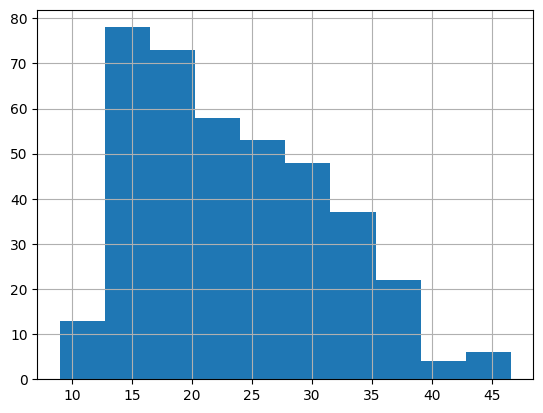

In [23]:
# Quickly inspect mpg distribution
data['MPG'].hist()

In [24]:
# Separate features and target
X = data.drop('MPG', axis=1).values
y = data['MPG'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [25]:
# Define Wave-Encoded Linear Layer
class WaveWeightLinear(nn.Module):
    def __init__(self, in_features, out_features, t_samples=8):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.t = torch.linspace(0, 2 * torch.pi, t_samples)  # Time vector

        # Wave parameters
        self.A = nn.Parameter(torch.randn(in_features, out_features))  # Amplitude
        self.omega = nn.Parameter(torch.rand(in_features, out_features))  # Frequency
        self.phi = nn.Parameter(torch.rand(in_features, out_features) * 2 * torch.pi)  # Phase

    def forward(self, x):
        # Generate waves: (in_features, out_features, t_samples)
        waves = self.A.unsqueeze(-1) * torch.sin(self.omega.unsqueeze(-1) * self.t + self.phi.unsqueeze(-1))

        # Modulate inputs: (batch, in_features, 1) * (1, in_features, out_features, t_samples)
        modulated = x.unsqueeze(-1).unsqueeze(-1) * waves.unsqueeze(0)

        # Sum over inputs and time average: (batch, out_features)
        out = torch.mean(modulated.sum(dim=1), dim=-1)  # Interference + time avg
        return out

# Define Wave-Encoded Neural Network
class WaveNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, t_samples=8):
        super().__init__()
        self.wave_layer1 = WaveWeightLinear(input_size, hidden_size, t_samples)
        self.wave_layer2 = WaveWeightLinear(hidden_size, hidden_size, t_samples)
        self.linear = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.sin(self.wave_layer1(x))
        x = self.relu(self.wave_layer2(x))
        x = self.linear(x)
        return x

In [27]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1
lr = 1e-4
num_epochs = 500
t_samples = 8  # Number of time samples for wave encoding
patience = 50

# Lists to store train and val losses
train_losses = []
val_losses = []

# Early stopping variables
best_val_loss = float('inf')
epochs_no_improve = 0

# Initialize model, loss, and optimizer
model = WaveNet(input_size, hidden_size, output_size, t_samples)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

with tqdm(total=num_epochs, leave=False) as pbar:
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for i, (batch_X, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Checkpointing and early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping at epoch {epoch}')
                break

        pbar.set_postfix({'Train Loss': f"{avg_train_loss:.4f}", 'Val Loss': f"{avg_val_loss:.4f}"})
        pbar.update(1)

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
    
# Evaluation
model.eval()
with torch.no_grad():
    train_preds = model(X_train)
    val_preds = model(X_test)
    train_loss = criterion(train_preds, y_train)
    val_loss = criterion(val_preds, y_test)

print(f'Train Loss: {train_loss.item():.4f}, Val Loss: {test_loss.item():.4f}')

# Example prediction
sample_input = X_test[0].unsqueeze(0)  # Take the first test sample
predicted_mpg = model(sample_input)
print(f'Predicted MPG: {predicted_mpg.item():.2f}, Actual MPG: {y_test[0].item():.2f}')

  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 4.6399, Val Loss: 5.8802
Predicted MPG: 27.82, Actual MPG: 26.00


<ipython-input-27-47c92fbfa544>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


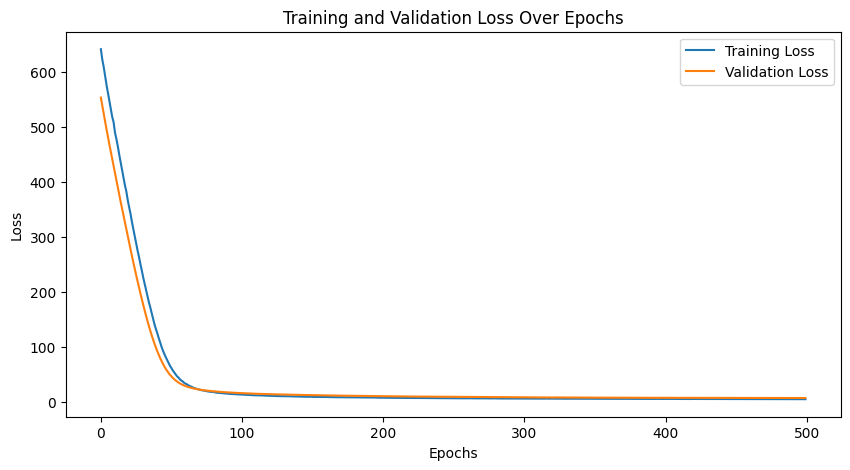

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [28]:
# Calculate metrics
val_r2 = r2_score(y_test, test_preds)
val_mae = mean_absolute_error(y_test, test_preds)
val_mse = mean_squared_error(y_test, test_preds)

print('Wave Network Performance:')
print(f'Val R²: {val_r2:.4f}')
print(f'Val MAE: {val_mae:.4f}')
print(f'Val MSE: {val_mse:.4f}')

Wave Network Performance:
Val R²: 0.8848
Val MAE: 1.8064
Val MSE: 5.8802


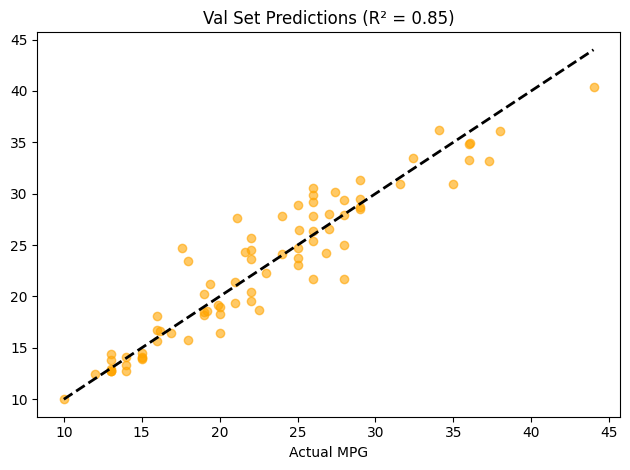

In [29]:
plt.scatter(y_test, test_preds, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title(f'Val Set Predictions (R² = {test_r2:.2f})')
plt.xlabel('Actual MPG')

plt.tight_layout()
plt.show()

In [30]:
# Convert PyTorch tensors back to numpy arrays for scikit-learn
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()
y_train_np = y_train.numpy()
y_test_np = y_test.numpy()

In [31]:
# Create a linear regression model with target transformation
regressor = LinearRegression()
transformer = lambda x: np.log1p(x)  # Transformation function
inverse_transformer = lambda x: np.expm1(x)  # Inverse transformation function

# Wrap the regressor with TransformTargetRegressor
ttr = TransformedTargetRegressor(regressor=regressor, func=transformer, inverse_func=inverse_transformer)

# Fit the model
ttr.fit(X_train_np, y_train_np)

# Make predictions
y_train_pred = ttr.predict(X_train_np)
y_test_pred = ttr.predict(X_test_np)

# Calculate metrics
test_r2 = r2_score(y_test_np, y_test_pred)
test_mae = mean_absolute_error(y_test_np, y_test_pred)
test_mse = mean_squared_error(y_test_np, y_test_pred)

print('Linear Regression Performance:')
print(f'Val R²: {test_r2:.4f}')
print(f'Val MAE: {test_mae:.4f}')
print(f'Val MSE: {test_mse:.4f}')

# TODO: Split into train-val-test so that we aren't conditioning ourselves on the val set

Linear Regression Performance:
Val R²: 0.8539
Val MAE: 1.9854
Val MSE: 7.4563


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


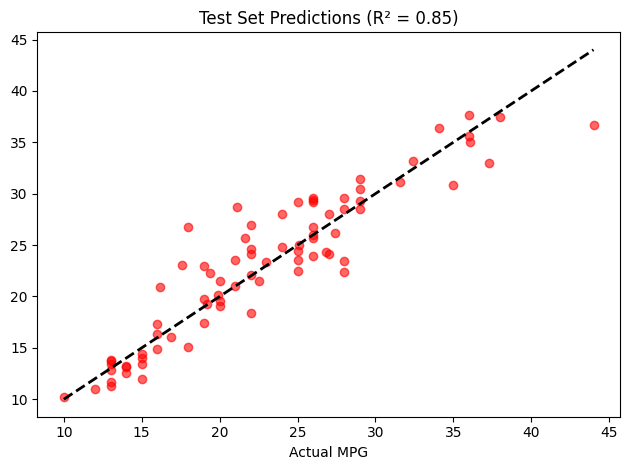

In [33]:
plt.scatter(y_test_np, y_test_pred, alpha=0.6, color='red')
plt.plot([y_test_np.min(), y_test_np.max()], 
         [y_test_np.min(), y_test_np.max()], 'k--', lw=2)
plt.title(f'Test Set Predictions (R² = {test_r2:.2f})')
plt.xlabel('Actual MPG')

plt.tight_layout()
plt.show()